## Modelo de Evaluation & Validation
## Projeto: Prever os preços da habitacao de Boston


## Ih vamos comecar!
Neste projeto, será avaliado o desempenho e o poder preditivo de um modelo que foi treinado e testado em dados coletados de casas nos subúrbios de Boston, Massachusetts. Um modelo treinado sobre esses dados que é visto como um *bom ajuste* poderia então ser usado para fazer certas previsões sobre uma casa - em particular, seu valor monetário. Este modelo provaria ser inestimável para alguém como um agente imobiliário que poderia fazer uso dessas informações diariamente.

O conjunto de dados deste projeto é originário do [Repositório de Machine Learning da UCI](https://archive.ics.uci.edu/ml/datasets/Housing). Os dados de habitação de Boston foram coletados em 1978 e cada uma das 506 entradas representam dados agregados sobre 14 características para casas de vários subúrbios de Boston, Massachusetts. Para efeitos deste projeto, as seguintes etapas de pré-processamento foram feitas ao conjunto de dados:
- 16 pontos de dados têm um valor ''MEDV'' de 50,0. Esses pontos de dados provavelmente contêm valores **ausentes ou censurados** e foram removidos.
- 1 ponto de dados tem um valor ''RM'' de 8,78. Este ponto de dados pode ser considerado um **outlier** e foi removido.
- As características ''RM'', ''LSTAT'', ''PTRATIO'', e ''MEDV'' são essenciais. As demais características **não relevantes** foram excluídas.
- O recurso ''MEDV'' foi **multiplicativamente dimensionado** para contabilizar 35 anos de inflação de mercado.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from sklearn.model_selection import ShuffleSplit

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Boston housing dataset
data = pd.read_csv('house.csv')
prices = data['MEDV']
features = data.drop('MEDV', axis = 1)
    
# Success
print("O conjunto de dados de habitação de Boston tem pontos de dados {} com variáveis {} cada.".format(*data.shape))

O conjunto de dados de habitação de Boston tem pontos de dados 489 com variáveis 4 cada.


## Exploracao de dados
Nesta primeira seção deste projeto, farei uma investigação superficial sobre os dados da habitação de Boston e fornecerei minhas observações.

Como o objetivo principal deste projeto é construir um modelo de trabalho que tenha a capacidade de prever o valor das casas, precisaremos separar o conjunto de dados em **características** e a variável **target**. Os recursos *, ''RM'',, ''LSTAT'', e ''PTRATIO', nos dão informações quantitativas sobre cada ponto de dados. A variável **target**, ''MEDV'', será a variável que buscamos prever. Estes são armazenados em 'características' e 'preços', respectivamente.

### Implementacao: Calcular Estatisticas

In [2]:
np.amin(prices)

105000.0

In [3]:
# Minimum price of the data
minimum_price = np.amin(prices)

# Maximum price of the data
maximum_price = np.amax(prices)

# Mean price of the data
mean_price = np.mean(prices)

# Median price of the data
median_price = np.median(prices)

# Standard deviation of prices of the data
std_price = np.std(prices)

# Show the calculated statistics
print("Statistics for Boston housing dataset:\n")
print("Minimum price: ${}".format(minimum_price)) 
print("Maximum price: ${}".format(maximum_price))
print("Mean price: ${}".format(mean_price))
print("Median price ${}".format(median_price))
print("Standard deviation of prices: ${}".format(std_price))

Statistics for Boston housing dataset:

Minimum price: $105000.0
Maximum price: $1024800.0
Mean price: $454342.9447852761
Median price $438900.0
Standard deviation of prices: $165171.13154429477


## Observando as features

Como lembrete, estamos usando três recursos do conjunto de dados de habitação de Boston: ''RM'', ''LSTAT'', e ''PTRATIO''. Para cada ponto de dados (bairro):
- ''RM'' é o número médio de quartos entre as casas do bairro.
- ''LSTAT'' é o percentual de proprietários no bairro considerado "classe baixa" (trabalhador pobre).
- ''PTRATIO'' é a proporção de alunos para professores em escolas de ensino fundamental e médio do bairro.

Intuitivamente, para cada recurso eu predito o seguinte:

- Casas com mais quartos (maior valor 'RM') valerão mais. Geralmente casas com mais quartos são maiores e podem caber mais pessoas, por isso é razoável que elas custam mais dinheiro. São variáveis diretamente proporcionais.
    
- Bairros com mais trabalhadores de classe baixa (maior valor 'LSTAT') valerão menos. Se o percentual de pessoas da classe trabalhadora mais baixa for maior, é provável que tenham baixo poder aquisitivo e, portanto, as casas custarão menos. São variáveis inversamente proporcionais.
    
- A proporção de bairros com mais alunos para professores (maior valor 'PTRATIO') valerá menos. Se a porcentagem de alunos para professores é maior, é provável que no bairro haja menos escolas, isso pode ser porque há menos renda de impostos que poderia ser porque naquele bairro as pessoas ganham menos dinheiro. Se as pessoas ganham menos dinheiro, é provável que suas casas valham menos. São variáveis inversamente proporcionais.

----

## Desenvolvendo o modelo
Nesta segunda seção do projeto, desenvolverei as ferramentas e técnicas necessárias para que um modelo faça uma previsão. Ser capaz de fazer avaliações precisas do desempenho de cada modelo através do uso dessas ferramentas e técnicas ajuda a reforçar muito a confiança em suas previsões.

### Implementacao: Defina uma Metrica de Desempenho

É difícil medir a qualidade de um determinado modelo sem quantificar seu desempenho em relação ao treinamento e testes. Isso é normalmente feito usando algum tipo de métrica de desempenho, seja através do cálculo de algum tipo de erro, da bondade do ajuste ou de alguma outra medição útil. Para este projeto, você ill estar calculando o [*coeficiente de determinação*](http://stattrek.com/statistics/dictionary.aspx?definition=coefficient_of_determination), R<sup>2</sup>, para quantificar o desempenho do modelo. O coeficiente de determinação para um modelo é uma estatística útil na análise de regressão, pois muitas vezes descreve o quão "bom" esse modelo é em fazer previsões. 

Os valores para R<sup>2</sup> variam de 0 a 1, o que captura o percentual de correlação quadrada entre os valores previstos e reais da variável **target**. Um modelo com um R<sup>2</sup> de 0 não é melhor do que um modelo que sempre prevê a *média* da variável alvo, enquanto um modelo com um R<sup>2</sup> de 1 prevê perfeitamente a variável alvo. Qualquer valor entre 0 e 1 indica qual porcentagem da variável alvo, usando este modelo, pode ser explicado pelos recursos ***. _A modelo pode receber um R<sup>2 negativo</sup> também, o que indica que o modelo é **arbitrariamente pior** do que aquele que sempre prevê a média da meta variable._

In [4]:
# Import 'r2_score'

from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calcula e devolve a pontuação de desempenho entre valores verdadeiros e previstos com base na métrica escolhida. """
    
    # TODO: Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

### Implementacao: Embaralhar e Dividir Dados
Para a próxima implementação é necessário pegar o conjunto de dados de habitação de Boston e dividir os dados em subconjuntos de treinamento e teste. Normalmente, os dados também são embaralhados em uma ordem aleatória ao criar os subconjuntos de treinamento e teste para remover qualquer viés na ordenação do conjunto de dados.

In [5]:
# Import 'train_test_split'
from sklearn.model_selection import train_test_split

# Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, prices, test_size=0.2, random_state = 42)

# Success
print("Treinamento e divisão de testes foi bem sucedido.")

Treinamento e divisão de testes foi bem sucedido.


### Treinamento e Teste

Você pode perguntar agora:

* Qual é o benefício de dividir um conjunto de dados em alguma proporção de subconjuntos de treinamento e teste para um algoritmo de aprendizagem?

É útil avaliar nosso modelo uma vez que ele é treinado. Queremos saber se ele aprendeu corretamente com uma divisão de treinamento dos dados. Pode haver 3 situações diferentes:

1) O modelo não aprendeu bem sobre os dados, e não pode prever nem mesmo os resultados do conjunto de treinamento, isso é chamado de subequiptação e é causado por um viés alto.

2) O modelo aprende muito bem os dados de treinamento, até o ponto em que memorizou e não é capaz de generalizar sobre novos dados, isso é chamado de overfiting, é causado porque alta variância.

3) O modelo só tinha o equilíbrio certo entre viés e variância, aprendeu bem e é capaz de prever corretamente os resultados em novos dados.

----

## Analisando o desempenho do modelo
Nesta terceira seção do projeto, vamos dar uma olhada no aprendizado de vários modelos e testar desempenhos em vários subconjuntos de dados de treinamento. Além disso, investigaremos um algoritmo em particular com um parâmetro crescente de ''max_depth'' no conjunto completo de treinamento para observar como a complexidade do modelo afeta o desempenho. Gráfico do desempenho do modelo com base em critérios variados pode ser benéfico no processo de análise, como visualizar comportamentos que podem não ter sido aparentes apenas a partir dos resultados.

### Curvas de Aprendizado
A célula de código a seguir produz quatro gráficos para um modelo de árvore de decisão com diferentes profundidades máximas. Cada gráfico visualiza as curvas de aprendizagem do modelo tanto para treinamento quanto para testes, pois o tamanho do conjunto de treinamento é aumentado. Note que a região sombreada de uma curva de aprendizado denota a incerteza dessa curva (medida como o desvio padrão). O modelo é pontuado tanto nos conjuntos de treinamento quanto de testes utilizando R<sup>2</sup>, o coeficiente de determinação.  

/home/carlos/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/carlos/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/carlos/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/carlos/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/carlos/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined wit

/home/carlos/Desktop/MachLab/visuals.py:68: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


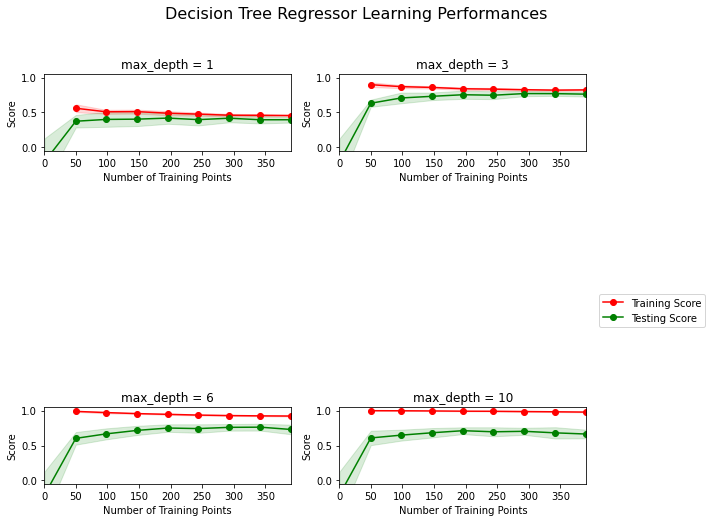

In [6]:
# Produce learning curves for varying training set sizes and maximum depths
vs.ModelLearning(features, prices)

### Aprendendo os dados

Se dermos uma olhada de perto no gráfico com a profundidade máxima de 3:

- À medida que o número de pontos de treinamento aumenta, a pontuação do treinamento diminui. Em contraste, a pontuação do teste aumenta.

- Como ambas as pontuações (treinamento e testes) tendem a convergir, a partir dos 300 pontos, ter mais pontos de treinamento não beneficiará o modelo.

- (Pergunta extra): Em geral, com mais colunas para cada observação, vamos obter mais informações e o modelo poderá aprender melhor com o conjunto de dados e, portanto, fazer melhores previsões.

### Curvas de Complexidade
A célula de código a seguir produz um gráfico para um modelo de árvore de decisão que foi treinado e validado nos dados de treinamento usando diferentes profundidades máximas. O gráfico produz duas curvas de complexidade — uma para treinamento e outra para validação. Semelhante às curvas de aprendizagem ***, as regiões sombreadas de ambas as curvas de complexidade denotam a incerteza nessas curvas, e o modelo é pontuado tanto nos conjuntos de treinamento quanto de validação usando a função 'performance_metric'.  

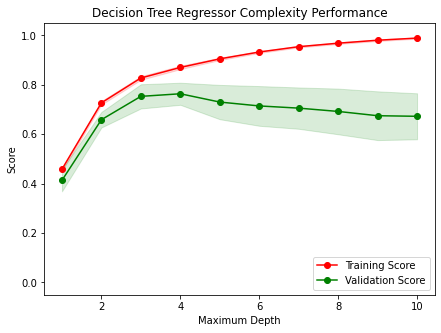

In [7]:
vs.ModelComplexity(X_train, y_train)

### Bias-Varince Tradeoff

Se analizarmos como a variância de viés varia com a profundidade máxima, podemos inferir que:

- Com a profundidade máxima de um, o gráfico mostra que o modelo não retorna uma boa pontuação nem em dados de treinamento nem teste, que é um sintoma de subajuste e, portanto, viés elevado. Para melhorar o desempenho, devemos aumentar a complexidade do modelo, neste caso aumentando o max_depth hiperparmetro para obter melhores resultados.

- Com a profundidade máxima de dez, o gráfico mostra que o modelo aprende perfeitamente bem com dados de treinamento (com uma pontuação próxima a uma) e também retorna resultados ruins em dados de teste, que é um indicador de excesso de adaptação, não sendo capaz de generalizar bem em novos dados. Este é um problema de Alta Variância. Para melhorar o desempenho, devemos diminuir a complexidade do modelo, neste caso diminuindo o max_depth hiperparmetro para obter melhores resultados.

### Melhor-Palpite Modelo Ideal

A partir da curva de complexidade, podemos inferir que a melhor profundidade máxima para o modelo é 4, pois é a que rende a melhor pontuação de validação.

Além disso, para maior profundidade, embora o escore de treinamento aumente, a pontuação de validação tende a diminuir, o que é um sinal de excesso de adaptação.

-----

## Avaliação do desempenho do modelo
Nesta seção final do projeto, construiremos um modelo e faremos uma previsão sobre o conjunto de recursos do cliente usando um modelo otimizado de 'fit_model'.

### Grid Search
* Qual é a técnica de grid search?
* Como ele pode ser aplicado para otimizar um algoritmo de aprendizagem?

A técnica de grid search gera exaustivamente os candidatos a partir de uma grade de valores de parâmetros especificados com o parâmetro param_grid, que é um dicionário com os valores dos hiperparmetros para avaliar. Um epíple pode ser:

param_grid =
  {'C': [1, 10, 100, 1000], 'kernel': ['linear'},
  {'C': [1, 10, 100, 1000], 'gama': [0,001, 0,0001], 'kernel': ['rbf'},
 ]
 
Neste exemplo, duas grids devem ser exploradas: uma com um núcleo linear de valores C de [1.10,100.1000], e a segunda com um kernel RBF, e a cruz de valores C variando em [1, 10, 100, 1000] e valores gama em [0,001, 0,0001].

Ao montagem em um conjunto de dados todas as combinações possíveis de valores de parâmetros são avaliadas e a melhor combinação é retida.

### Cross-Validation

* Qual é a técnica de treinamento de validação cruzada k-fold? 

* Qual o benefício dessa técnica para a busca na grade ao otimizar um modelo?

K-fold validação cruzada é uma técnica usada para garantir que nosso modelo seja bem treinado, sem usar o conjunto de testes. Consiste em dividir dados em divisórias k de tamanho igual. Para cada partição i, treinamos o modelo nos parâmetros k-1 restantes e avaliamos-no em partição i. A pontuação final é a média dos pontos K obtidos.

Ao avaliar diferentes hiperparmetros para estimadores, ainda há o risco de superequipamento no conjunto de testes, pois os parâmetros podem ser ajustados até que o estimador funcione de forma ideal. Dessa forma, o conhecimento sobre o conjunto de testes pode "vazar" no modelo e as métricas de avaliação não informam mais sobre o desempenho de generalização. Para resolver esse problema, outra parte do conjunto de dados pode ser mantida como um chamado "conjunto de validação": o treinamento prossegue no conjunto de treinamento, após o qual a avaliação é feita no conjunto de validação, e quando o experimento parece ter sucesso, a avaliação final pode ser feita no conjunto de testes.

No entanto, particionando os dados disponíveis em três conjuntos (conjuntos de treinamento, validação e testes), reduzimos drasticamente o número de amostras que podem ser usadas para aprender o modelo, e o modelo resultante pode não ser suficientemente bem treinado (subequipar).

Usando a validação k-fold, garantimos que o modelo use todos os dados de treinamento disponíveis para sintonizar o modelo, ele pode ser computacionalmente caro, mas permite treinar modelos mesmo que poucos dados estejam disponíveis.

O principal objetivo da validação k-fold é obter uma estimativa imparcial da generalização do modelo em novos dados.

### Implementacao: Treinando o modelo
A implementação final exige que unamos tudo e treinemos um modelo usando o algoritmo da árvore de decisão**. Para garantir que estamos produzindo um modelo otimizado, treinaremos o modelo usando a técnica de busca de grade para otimizar o parâmetro ''max_depth'' para a árvore de decisão. O parâmetro ''max_depth'' pode ser pensado como quantas perguntas o algoritmo da árvore de decisão pode fazer sobre os dados antes de fazer uma previsão. As árvores de decisão fazem parte de uma classe de algoritmos chamados algoritmos de aprendizagem supervisionados*.

Além disso, descobriremos que sua implementação está usando 'ShuffleSplit()' para uma forma alternativa de validação cruzada (veja a variável ''cv_sets'). A implementação 'ShuffleSplit()' abaixo criará 10 conjuntos embaralhados (''n_splits'') embaralhados, e para cada embaralhado, 20% (''test_size'') dos dados serão usados como o conjunto *validação*.


In [8]:
# Import 'make_scorer', 'DecisionTreeRegressor', and 'GridSearchCV'
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.20, random_state = 0)

    # Create a decision tree regressor object
    regressor = DecisionTreeRegressor()

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth':[1,2,3,4,5,6,7,8,9,10]}

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # Create the grid search cv object --> GridSearchCV()
    # Make sure to include the right parameters in the object:
    # (estimator, param_grid, scoring, cv) which have values 'regressor', 'params', 'scoring_fnc', and 'cv_sets' respectively.
    grid = GridSearchCV(estimator=regressor, param_grid=params, scoring=scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

### Fazendo Previsoes
Uma vez que um modelo tenha sido treinado em um determinado conjunto de dados, ele agora pode ser usado para fazer previsões sobre novos conjuntos de dados de entrada. No caso de um *regressor de árvore de decisão*, o modelo aprendeu *quais são as melhores perguntas a fazer sobre os dados de entrada*, e pode responder com uma previsão para a variável **target**. Podemos usar essas previsões para obter informações sobre dados onde o valor da variável alvo é desconhecido — como dados em que o modelo não foi treinado.

### Modelo Otimo

* Que profundidade máxima o modelo ideal tem? 

In [9]:
# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print("O parâmetro 'max_depth' é {} para o modelo ideal.".format(reg.get_params()['max_depth']))

O parâmetro 'max_depth' é 4 para o modelo ideal.


### Prever precos de venda
Imagine que éramos um agente imobiliário na área de Boston procurando usar este modelo para ajudar a precificar casas de propriedade de nossos clientes que eles desejam vender. Você coletou as seguintes informações de três de seus clientes:

| Característica | Cliente 1 | Cliente 2 | Cliente 3 |
| :---: | :---: | :---: | :---: |
| Número total de quartos em casa | 5 quartos | 4 quartos | 8 quartos |
| Nível de pobreza de bairro (como %) | 17% | 32% | 3% |
| Relação aluno-professor de escolas próximas | 15 para 1 | 22 para 1 | 12 para 1 |

* A que preço recomendaríamos que cada cliente vendesse sua casa? 
* Esses preços parecem razoáveis dado os valores para as respectivas características? 

In [10]:
# Produce a matrix for client data
client_data = [[5, 17, 15], # Client 1
               [4, 32, 22], # Client 2
               [8, 3, 12]]  # Client 3

# Show predictions
for i, price in enumerate(reg.predict(client_data)):
    print("Preço de venda previsto para a casa do cliente {}: ${:,.2f}".format(i+1, price))

Preço de venda previsto para a casa do cliente 1: $403,025.00
Preço de venda previsto para a casa do cliente 2: $237,478.72
Preço de venda previsto para a casa do cliente 3: $931,636.36


**Resposta: **

Os preços de venda previstos são:

- Para a casa do Cliente 1: $403.025,00

- Para a casa do Cliente 2: $237.478,72

- Para a casa do Cliente 3: $931.636.36

A partir da questão 1, obtivemos as seguintes estatísticas:

- Preço mínimo: $105000.0

- Preço máximo: $1024800.0

- Preço médio: $454342.9447852761

- Preço médio $438900.0

- Desvio padrão de preços: $165340.27765266786

Dado esses valores, podemos concluir:

- O preço de venda do cliente 3 está próximo do milhão de dólares, que está perto do máximo do conjunto de dados. Este é um preço razoável por causa de suas características (8 quartos, nível de pobreza muito baixo e baixa relação aluno-professor), a casa pode estar em um bairro rico.

- O preço de venda para o cliente 2 é o mais baixo dos três e dado que suas características são razoáveis, pois está perto do mínimo do conjunto de dados.

- Para o cliente 1, podemos ver que suas características são intermediárias entre as últimas 2 e, portanto, seu preço é bastante próximo da média e mediana.

Como indicado na Questão 1:

- 'RM', tem relação direta proporcional com a variável dependente 'Preços'.
- Em contrapartida, 'LSTAT' e 'PTRATIO' têm uma relação inversamente proporcional com a variável dependente 'PRICES'.

### Sensibilidade
Um modelo ideal não é necessariamente um modelo robusto. Às vezes, um modelo é muito complexo ou muito simples para generalizar suficientemente novos dados. Às vezes, um modelo poderia usar um algoritmo de aprendizagem que não é apropriado para a estrutura dos dados dados. Outras vezes, os dados em si podem ser muito barulhentos ou conter poucas amostras para permitir que um modelo capture adequadamente a variável alvo — ou seja, o modelo é subjustificado. 

**A célula de código abaixo executa a função 'fit_model' dez vezes com diferentes conjuntos de treinamento e testes para ver como a previsão para um cliente específico muda em relação aos dados em que é treinado.**

In [11]:
vs.PredictTrials(features, prices, fit_model, client_data)

Trial 1: $391,183.33
Trial 2: $419,700.00
Trial 3: $415,800.00
Trial 4: $420,622.22
Trial 5: $418,377.27
Trial 6: $411,931.58
Trial 7: $399,663.16
Trial 8: $407,232.00
Trial 9: $351,577.61
Trial 10: $413,700.00

Range in prices: $69,044.61


### Aplicabilidade

Agora, usamos esses resultados para discutir se o modelo construído deve ou não ser usado em um cenário do mundo real. Algumas perguntas que valem a pena responder: 

- Quão relevantes hoje são os dados coletados de 1978? Qual é a importância da inflação?
- As características presentes nos dados são suficientes para descrever uma casa? Você acha que fatores como qualidade de apliques em casa, metros quadrados da área do enredo, presença de piscina ou não etc deve fatorar?
- O modelo é robusto o suficiente para fazer previsões consistentes?
- Os dados coletados em uma cidade urbana como Boston seriam aplicáveis em uma cidade rural?
- É justo julgar o preço de uma casa individual com base nas características de todo o bairro?

**Resposta: **

Obtivemos uma faixa de preços de quase 70k$, acredito que este é um desvio bastante grande, pois representa aproximadamente 17% do valor médio dos preços das casas. Por causa disso, o modelo não deve ser usado em um cenário do mundo real.

- Os dados coletados de 1978 não têm muito valor no mundo atual, a sociedade e a economia mudaram tanto e, em geral, a inflação tem impactado muito os preços.

- O conjunto de dados considerado é bastante limitado, há uma série de características como o tamanho da casa em metros quadrados, a presença de piscina ou não e outras, que são muito relevantes quando se considera um preço de casa.

- Dada a alta variância na faixa do príncipe, podemos garantir que não é um modelo robusto e, portanto, não appropia para fazer previsões.

- Dados coletados de uma grande cidade urbana como Boston não seriam aplicáveis em uma cidade rural, pois pelo mesmo valor dos feaures os preços são muito mais elevados na área urbana.

- Em geral, não é justo estimar ou prever o preço de uma casa simples com base nas características de todo o bairro. No mesmo bairro pode haver enormes diferenças de preços.